# Modelo DNN




En este cuaderno de Jupyter se construye el modelo Random Forest usando los hiperparámetros calculados en el cuaderno `hiperparamtros_DNN.ipynb` 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

# Escalamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# modelo DNN
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import TimeSeriesSplit

## Lectura de datasets 

In [2]:
# Nombre de las acciones
tickers = [
    'TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA',
    'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL',
    'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT',
    'SMIN', 'SSE', 'VOD'
]

data_frames = {} # Inicializo diciconario de data frames

for ticker in tickers: 
    
    df = pd.read_csv(f'datasets_features/{ticker}.csv')  # leo el dataset
    data_frames[ticker] = df                             # guardo dataframes
    
print(data_frames.keys())

dict_keys(['TSCO', 'AZN', 'BARC', 'BP', 'BATS', 'HLMA', 'HSBA', 'JMAT', 'LGEN', 'MKS', 'PSON', 'REL', 'NWG', 'SHEL', 'SGE', 'SBRY', 'SDR', 'SVT', 'SMIN', 'SSE', 'VOD'])


## Función para 1 bloque - 1 acción 

In [3]:
def modelo_DNN(df_bloque, model):
    '''
    Dado un bloque de 1000 días, esta función usa el 'Modelo DNN' para predecir. 
    Parametros:
    -----------
        df_bloque : pd.DataFrame con bloque de 1000 días. 
            Contiene los 20 features + (open, close, high, low,...)
        model : modelo a aplicar
    
    Return:
    -------
        diccionario : devuelve un diccionario con los resultados de prediciones y metricas. 
            Tiene como claves: y_pred, y_test, y_pred_s, y_test_s, y_pre_close, y_test_close, metrics
    
    '''
    
    # 1) ------------- Partición de datos ---------------- 
    
    df_features = df_bloque.drop(columns=['Date', 'Open', 'High', 'Low','Close','Volume', 'prev_close', 'target']) # todas columnas r_i
    target      = df_bloque['target']  # columna del target
    close       = df_bloque['Close']   # columna precio cierre
    
    ini_train, fin_train = 0, 749 
    ini_test, fin_test = 750, 999 
    
    X_train = df_features.iloc[ : fin_train + 1]
    X_test  = df_features.iloc[ini_test : fin_test + 1]
    y_train = target.iloc[ : fin_train + 1]
    y_test  = target.iloc[ini_test : fin_test + 1]
    y_test_close = close.iloc[ini_test : fin_test + 1]

    # 2) ----------- Estandarización ---------------------
    # Features 
    scaler_x = MinMaxScaler(feature_range=(-1,1))
    X_train_s = scaler_x.fit_transform(X_train)     
    X_test_s  = scaler_x.transform(X_test)

    # Target (al estandarizar son 2D)
    scaler_y = MinMaxScaler(feature_range=(-1,1))
    y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel() # Necesario reshape, scaler espera 2D      
    y_test_s  = scaler_y.transform(y_test.values.reshape(-1, 1))

    # 3) ---------- Entrenamiento y predicción del modelo --------------------
    
    model.fit(X_train_s, y_train_s, verbose=0)
    y_pred_s = model.predict(X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1, 1)).ravel() 
    
    # en caso de no estandarizar
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_test)

    
    # Predicción de los precios   
    P_real_test = close.iloc[ini_test : fin_test+1]  # 250 precios: desde P_750 hasta P_999
    y_pred_close = np.zeros(249)                # 249 predicciones de P_close: desde P_751 hasta P_999

    for k in range(len(y_pred_close)): 
        y_pred_close[k] = P_real_test.iloc[k]*np.exp(y_pred[k])  
        # ojo: las predicciones y_pred_close = [P_751, P_752, ... , P_999] 
        # empiezan en 751 porque P_750 ya lo conozco al disponer de y_749
    
    
    # 4) ---------- Cálculo de métricas ------------------
    mse   = mean_squared_error(y_true = y_test, y_pred = y_pred)     
    mse_s = mean_squared_error(y_true = y_test_s, y_pred = y_pred_s)
    rmse   = np.sqrt(mse)
    rmse_s = np.sqrt(mse_s)
    mae   = mean_absolute_error(y_true = y_test, y_pred = y_pred)
    mae_s = mean_absolute_error(y_true = y_test_s, y_pred = y_pred_s)
    r2   = r2_score(y_true = y_test, y_pred = y_pred)
    r2_s = r2_score(y_true = y_test_s, y_pred = y_pred_s)
    
    #print('Precios reales:\n', close.iloc[745:753])
    #print('Predicciones de precio desde P_751...P_999:\n', y_pred_close[0:5])
    
    # --------------- Returns ---------------------
    diccionario = {}
    diccionario['y_pred'] = y_pred
    diccionario['y_test'] = y_test.values
    diccionario['y_pred_s'] = y_pred_s
    diccionario['y_test_s'] = y_test_s
    diccionario['metrics'] = {'mse':mse, 'rmse':rmse, 'mae':mae, 'r2':r2}
    diccionario['metrics_s'] = {'mse_s':mse_s, 'rmse_s':rmse_s, 'mae_s':mae_s, 'r2_s':r2_s}
    
    # para los gráficos del Precio cierre 
    diccionario['y_pred_close'] = y_pred_close
    diccionario['y_test_close'] = close.iloc[ini_test+1 : fin_test+1].values # 249 valores [P_751,...,P_999]
    
    
    return diccionario 


## Construcción del modelo 

In [4]:

#Construyo modelo 
DNN_model = tf.keras.Sequential()

# Capa oculta 0
DNN_model.add(layers.Dense(
    units=32,
    activation='tanh',
    kernel_regularizer=regularizers.l2(0.01)
))
DNN_model.add(layers.Dropout(0.5))   # 0.5

# Capa de salida
DNN_model.add(layers.Dense(1))

# Optimizador
#opt = tf.keras.optimizers.Adam(learning_rate=0.001) #0.001
opt = tf.keras.optimizers.RMSprop(learning_rate=0.01) #0.001

# Compilar
DNN_model.compile(
    optimizer=opt,
    loss='mse'
)

**Ejemplo:**

In [5]:
# Elijo un data set
df = data_frames['AZN']

# Calculo predicciones y métricas
display(modelo_DNN(df[0:1000], model = DNN_model)['metrics'])

8/8 [==============================] - 0s 2ms/step


{'mse': 0.0018468633637313075,
 'rmse': 0.04297514821069623,
 'mae': 0.03963117741265225,
 'r2': -8.609365902211273}

## Modelo sobre todos los datasets y todos los bloques 

Ahora para cada uno de los bloques y cada una de las acciones, calculamos las correspondientes predicciones y métricas usando la función anteriormente definida. 

In [6]:
# Alamacenaré mis resultados en un diccionario
resultados = {}

for ticker, df in data_frames.items(): 
    print(f'Calculando {ticker}.')
    
    resultados[ticker] = {}
    #dicc_resultados[ticker]['metricas'] = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'R2']

    for n_bloque in range(20): 
        
        # inicializo paara guardar resultados
        bloque_name = f'Bloque_{n_bloque}'
        resultados[ticker][bloque_name] = {'predicciones': pd.DataFrame(columns=['y_test', 'y_pred', 'y_test_close', 'y_pred_close']),
                                           'metricas': pd.DataFrame(columns=['mse', 'rmse', 'mae', 'r2'])
                                          }
        ini_bloque = 250*n_bloque
        fin_bloque = 250*n_bloque + 999
        df_bloque = df.iloc[ini_bloque : fin_bloque + 1]
        #print(f'Bloque {n_bloque}: ini_bloque ({ini_bloque}:{fin_bloque}) - len={df_bloque.shape}')
        
        # CALCULO UN SOLO BLOQUE
        dicc_bloque = modelo_DNN(df_bloque, model=DNN_model)
        
        mse  = dicc_bloque['metrics']['mse']
        rmse = dicc_bloque['metrics']['rmse']
        mae  = dicc_bloque['metrics']['mae']
        r2   = dicc_bloque['metrics']['r2']
        
        # Almaceno predicciones de cada bloque
        resultados[ticker][bloque_name]['predicciones']['y_test'] = dicc_bloque['y_test']
        resultados[ticker][bloque_name]['predicciones']['y_pred'] = dicc_bloque['y_pred']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_test_close'] = dicc_bloque['y_test_close']
        resultados[ticker][bloque_name]['predicciones'].loc[1:, 'y_pred_close'] = dicc_bloque['y_pred_close']
        resultados[ticker][bloque_name]['metricas'].loc[bloque_name]     = [mse, rmse, mae, r2]

Calculando TSCO.
8/8 [==============================] - 0s 3ms/step
Calculando AZN.
8/8 [==============================] - 0s 3ms/step
Calculando BARC.
8/8 [==============================] - 0s 4ms/step
Calculando BP.
8/8 [==============================] - 0s 3ms/step
Calculando BATS.
8/8 [==============================] - 0s 2ms/step
Calculando HLMA.
8/8 [==============================] - 0s 2ms/step
Calculando HSBA.
8/8 [==============================] - 0s 2ms/step
Calculando JMAT.
8/8 [==============================] - 0s 2ms/step
Calculando LGEN.
8/8 [==============================] - 0s 2ms/step
Calculando MKS.
8/8 [==============================] - 0s 4ms/step
Calculando PSON.
8/8 [==============================] - 0s 3ms/step
Calculando REL.
8/8 [==============================] - 0s 3ms/step
Calculando NWG.
8/8 [==============================] - 0s 2ms/step
Calculando SHEL.
8/8 [==============================] - 0s 0s/step
Calculando SGE.
8/8 [==============================] - 

In [53]:
# Ejemplo: acción AZN - Bloque 0
display(resultados['AZN']['Bloque_0'].keys())
display(resultados['AZN']['Bloque_0']['predicciones'])
display(resultados['AZN']['Bloque_0']['metricas'])

dict_keys(['predicciones', 'metricas'])

,y_test,y_pred,y_test_close,y_pred_close
0,-0.009465,0.007492,NaN,NaN
1,-0.015508,0.006718,1727.500977,1757.043694
2,-0.012863,0.004446,1700.917236,1739.14573
3,-0.009545,0.004113,1679.179077,1708.497003
4,0.014713,-0.003871,1663.227173,1686.100285
...,...,...,...,...
245,-0.026434,0.003152,2112.079102,2156.276266
246,0.004691,0.002719,2056.979736,2118.746725
247,0.012546,0.001684,2066.651855,2062.581339
248,0.005530,0.001765,2092.744385,2070.135444


,mse,rmse,mae,r2
Bloque_0,0.000219,0.014785,0.011643,-0.137386


En la tabla de predicciones vemos que las predicciones de los precios de cierre tienen valores Nan en la primera fila. Esto es coherente con lo que hemos planteado: hemos dicho anteriormente que los precios de cierre predichos son 249 -> [P_751, P_752, ...., P_999]. 
Mientras que los log-retornos predichos (el target) son 250. 

### Guardo dataframe de métricas 

In [88]:
# Creo mi data frame de métricas (filas = acciones, columnas = metrica)

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

# inicializo data frame
df_intermedio = pd.DataFrame(columns=['mse','rmse','mae','r2'])
df_metricas = pd.DataFrame(columns=['MSE','RMSE','MAE','R2'])


for ticker in tickers:
    for bloque in bloques: 
        # Junto las metricas de cada bloque (misma ticker/accion)
        df_intermedio.loc[bloque] = resultados[ticker][bloque]['metricas'].loc[bloque].values

    # Calculo media sobre todos los bloques 
    medias = df_intermedio.mean()
    
    # Almaceno los resultados en un nuevo data frame
    df_metricas.loc[ticker] = medias.values

    
    
# Almaceno data frame en fichero externo 
carpeta = os.path.join(os.getcwd(), 'resultados_metricas')
os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
ruta_archivo = os.path.join(carpeta, f'metricas_modelo_DNN.csv')
df_metricas.to_csv(ruta_archivo, index=True) # Se guarda el índice (el nombre las de acciones)
    
display(df_metricas)

,MSE,RMSE,MAE,R2
TSCO,0.000570,0.021130,0.016999,-1.349577
AZN,0.000312,0.016988,0.012577,-0.115463
BARC,0.000864,0.025702,0.018845,-0.037376
BP,0.000308,0.016794,0.012511,-0.016770
BATS,0.000299,0.015810,0.011835,-0.033952
HLMA,0.000297,0.016807,0.011950,-0.027091
HSBA,0.000378,0.017770,0.013420,-0.234166
JMAT,0.000427,0.019620,0.014439,-0.027652
LGEN,0.000699,0.023763,0.017395,-0.067588
MKS,0.000966,0.026049,0.020803,-1.175676


### Guardo dataframe de predicciones

In [58]:
# Almaceno los dataframes de las predicciones en un fichero externo 

tickers = list(resultados.keys())
bloques = list(resultados['AZN'].keys())

for ticker in tickers:
    for bloque in bloques: 
        df_predicciones = resultados[ticker][bloque]['predicciones']
        
        # Almaceno data frame en fichero externo 
        carpeta = os.path.join(os.getcwd(), 'resultados_predicciones', 'modelo_DNN')
        os.makedirs(carpeta, exist_ok=True) # Crear la carpeta si no existe
        ruta_archivo = os.path.join(carpeta, f'predicciones_{ticker}_{bloque}.csv')
        df_predicciones.to_csv(ruta_archivo, index=False) # No se guarda el índice en predicciones


## Gráfica de un 1 bloque - 1 acción

In [54]:
# Elijo acción y bloque 
ticker_name = 'AZN'
bloque_name = 'Bloque_0'   

y_real = resultados[ticker_name][bloque_name]['predicciones']['y_test']
y_pred = resultados[ticker_name][bloque_name]['predicciones']['y_pred']
    
y_real_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_test_close']
y_pred_close = resultados[ticker_name][bloque_name]['predicciones'].loc[1:, 'y_pred_close']

print(len(y_real))
print(len(y_real_close))

250
249


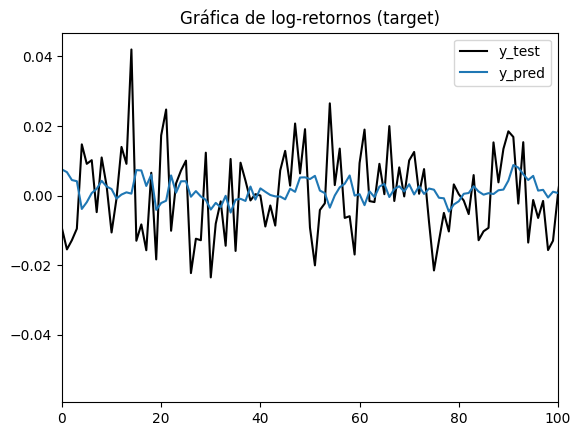

In [55]:
# Gráfica de log-retornos (target)

fig, ax = plt.subplots()
ax.plot(y_real, color='black', label='y_test')
ax.plot(y_pred, color='C0', label = 'y_pred')

# Cambio rango para ver mejor
plt.xlim([0,100])

plt.legend()
plt.title('Gráfica de log-retornos (target)')
plt.show()

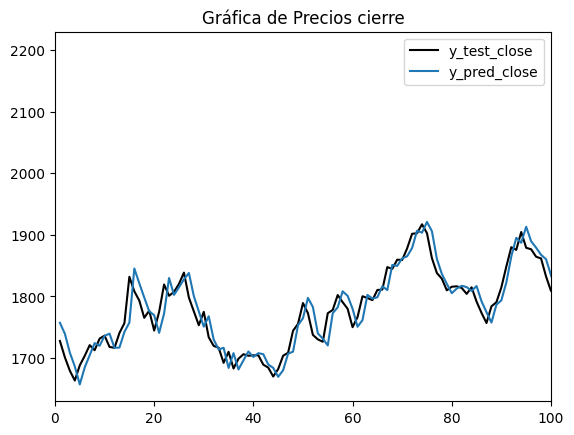

In [56]:
# Gráfica de precios cierre

fig, ax = plt.subplots()
ax.plot(y_real_close, color='black', label='y_test_close')
ax.plot(y_pred_close, color='C0', label = 'y_pred_close')

# Cambio rango para ver mejor
plt.xlim([0,100])

plt.legend()
plt.title('Gráfica de Precios cierre')
plt.show()